In [1]:
# Model structure
# input layer >> 2D CNN >> 1D CNN >> RNN (LSTM)  >> output layer (Dense)

### Import module

In [2]:
from glob import glob
import os, sys
from os.path import join, dirname

import datetime, time
import csv
from glob import glob
import chardet
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Dense, SimpleRNN, LSTM, GRU, Reshape, Dropout, MaxPooling2D
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import model_to_dot

from IPython.display import SVG

import imblearn

import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)
device_lib.list_local_devices()

2.3.1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10961225440783160798,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4902796621506312356
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3129973147
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17369848879646053091
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13187895973568613677
 physical_device_desc: "device: XLA_GPU device"]

### Global Parameter

In [3]:
num_classes = 8                           # {"0" : "Playing", "1" : "Talking", "2" : "Petting", "3" : "TV / Radio", "4" : "Eating / Cooking", "5" : "Moved It", "6" : "None of the above", "7" : "Other"}
time_offset = 10
window_size = 10
overlap_ratio = 0.5
bi_class = 4                              # Binary Classification (1 : Playing or not, 2 : Talking or not, 3 : Petting or not, 4: TV / Radio or not, 5 : Eating / Cooking or not, 6 : Moved It or not)
cross_val = 0
rand_st=1

### Load Data

In [4]:
data_fname = '../Data/Preprocessed/preprocessed_data(old).csv'

In [5]:
data = pd.read_csv(data_fname)
data = pd.concat([data,pd.get_dummies(data['sound_cat'])],axis=1)         # Onehot encode sound category
data = pd.concat([data,pd.get_dummies(data['orient'])],axis=1)            # Onehot encode Orient

### Preprocess Data

In [6]:
# Create rowID list
rowID_list = np.array(data['RowID'].drop_duplicates())
data = data.to_records(index=False)

In [7]:
for i in range(len(data)):
    #Convert string to num
    if data[i]['sound_cat'] == 'Quiet':
        data[i]['sound_cat'] = 0
    elif data[i]['sound_cat'] == 'Moderate':
        data[i]['sound_cat'] = 1
    else:
        data[i]['sound_cat'] = 2
    
    if data[i]['orient'] == 'Portrait Up':
        data[i]['orient'] = 0
    elif data[i]['orient'] == 'Portrait Down':
        data[i]['orient'] = 1
    elif data[i]['orient'] == 'Landscape Right':
        data[i]['orient'] = 2
    elif data[i]['orient'] == 'Landscape Left':
        data[i]['orient'] = 3
    else:
        data[i]['orient'] = 4

In [8]:
feature_col_name = ['awake', 'sound_val', 'light_val', 'accel_x', 'accel_y', 'accel_z', 'chord', 'motion_detect','sound_detect)',
                   'Loud', 'Moderate', 'Quiet', 'Flat', 'Landscape Left', 'Landscape Right', 'Portrait Down', 'Portrait Up']
target_col_name = ['Modality_cat']

In [9]:
X = []
Y = []

for rowID in rowID_list:
    #Split raw data by rowID & split X, Y data
    tmp_data = data[data['RowID'] == rowID]
    feature = tmp_data[feature_col_name]
    feature = np.array(feature.tolist())
    target = tmp_data[target_col_name][0][0]
    target = np.array(target.tolist())
    X.append(feature)
    Y.append(target)

In [10]:
if bi_class != 0:
    #Transit multi classification to binary classification
    for idx in range(len(Y)):
        if Y[idx] == bi_class-1:
            Y[idx]=1
        else:
            Y[idx]=0

In [11]:
def X_preprocess(X, window_size, overlap_ratio):
    #Transform data shape using the set time window
    processed_X = []
    
    for i in range(len(X)):
        tmp_X = X[i]
        tmp = []
        start_row = 0
        end_row = start_row + window_size
        
        if len(tmp_X)%int(window_size*overlap_ratio) == 0:
            for j in range(len(tmp_X)//int(window_size*overlap_ratio)-1):
                tmp.append(tmp_X[int(start_row):int(end_row)])
                start_row += (window_size*overlap_ratio)
                end_row += (window_size*overlap_ratio)
        else:
            for j in range(len(tmp_X)//int(window_size*overlap_ratio)+1):
                if end_row > len(tmp_X):
                    
                    tmp.append(tmp_X[-window_size:])
                    start_row += (window_size*overlap_ratio)
                    end_row += (window_size*overlap_ratio)
                    break
                else:
                    
                    tmp.append(tmp_X[int(start_row):int(end_row)])
                    start_row += (window_size*overlap_ratio)
                    end_row += (window_size*overlap_ratio)
        processed_X.append(tmp)
        
    return processed_X

In [12]:
X = X_preprocess(X, window_size, overlap_ratio)        ### preprocess with input shape
if bi_class == 0:
    ### onehot encode Y
    Y = np.eye(num_classes)[Y]
else: Y = np.eye(2)[Y]

In [13]:
# Fit to minimum length

min_len = 99999999
min_X = []

for x in X:
    if len(x) < min_len:
        min_len = len(x)

for x in X:
    min_X.append(x[:min_len])

In [14]:
# Drop duplicate

if bi_class != 0:
    target_list = []
    del_list = []

    for i in range(len(Y)):
        if Y[i][1] == 1:
            target_list.append(i)
    
    for i in target_list:
        for j in range(len(min_X)):
            if j in target_list:
                pass
            else:
                if np.array_equal(np.array(min_X[i]), np.array(min_X[j])):
                    if j not in del_list:
                        del_list.append(j)
    X = []
    Target = []
    
    for i in range(len(Y)):
        if i not in del_list:
            X.append(min_X[i])
            Target.append(Y[i])

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Target, test_size=0.2)

### Model

In [16]:
def build_model(num_classes, rnn_unit, input_shape):
    """ build CNN-RNN model """

    feature_input = Input(shape=input_shape)
    
    cnn_layer = Conv2D(1, 1, padding='same', activation='relu', name='conv1')(feature_input)
#     cnn_layer = MaxPooling2D(pool_size=(2, 2))(cnn_layer)
    
    rnn_input = Reshape((-1, rnn_unit), name='reshape1')(cnn_layer)
    rnn_layer = LSTM(units=rnn_unit, activation='relu', recurrent_activation='sigmoid', return_sequences=None, name='rnn1')(rnn_input)
    rnn_output = Dense(units=num_classes, activation='softmax', name='fc1')(rnn_layer)
    
    model = Model(inputs=feature_input, outputs=rnn_output, name='CRNN')
    
    return model

In [17]:
def get_divisor(n):
    n = int(n)
    divisors = []
    divisors_back = [] 

    for i in range(1, int(n**(1/2)) + 1): 
        if (n % i == 0):            
            divisors.append(i)
            if (i != (n // i)): 
                divisors_back.append(n//i)

    return divisors + divisors_back[::-1]

### Train model

In [18]:
if bi_class == 0:    
    model = build_model(num_classes=num_classes, rnn_unit=100, input_shape=np.array(X_train[0]).shape)
    model.summary()
    plot_model(model, show_shapes=True, to_file='model.png')
    plt = SVG(model_to_dot(model).create(prog='dot', format='svg')) 
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', keras.metrics.AUC(), tfa.metrics.F1Score(num_classes=num_classes)])
else:
    sm = imblearn.over_sampling.SMOTE()         # random state do not set
    origin_shape = np.array(X_train).shape
    new_X_train = np.array(X_train).reshape(origin_shape[0], origin_shape[1]*origin_shape[2]*origin_shape[3])
    Y_train = np.array(Y_train).astype('float64')
    X_train, Y_train = sm.fit_resample(new_X_train, Y_train)
    temp = X_train.shape
    X_train = X_train.reshape([temp[0], origin_shape[1], origin_shape[2], origin_shape[3]])
    Y_train = np.eye(2)[Y_train.reshape(temp[0])]
    model = build_model(num_classes=2, rnn_unit=20, input_shape=np.array(X_train[0]).shape)
    model.summary()
    plot_model(model, show_shapes=True, to_file='model.png')
    SVG(model_to_dot(model).create(prog='dot', format='svg')) 
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', keras.metrics.AUC()])
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', auc])

C:\Users\sckim\.conda\envs\grad\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Model: "CRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 10, 17)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 20, 10, 1)         18        
_________________________________________________________________
reshape1 (Reshape)           (None, 10, 20)            0         
_________________________________________________________________
rnn1 (LSTM)                  (None, 20)                3280      
_________________________________________________________________
fc1 (Dense)                  (None, 2)                 42        
Total params: 3,340
Trainable params: 3,340
Non-trainable params: 0
_________________________________________________________________


In [19]:
hist = model.fit(x=np.array(X_train).transpose([0,1,2,3]), y=Y_train, batch_size=None, validation_split=0, epochs=500)

Epoch 1/500
4/4 [==============================] - 0s 21ms/step - loss: 5.1335 - accuracy: 0.6083 - auc: 0.5765
Epoch 2/500
4/4 [==============================] - 0s 14ms/step - loss: 4.4229 - accuracy: 0.4750 - auc: 0.4844
Epoch 3/500
4/4 [==============================] - 0s 14ms/step - loss: 3.5703 - accuracy: 0.5000 - auc: 0.5288
Epoch 4/500
4/4 [==============================] - 0s 15ms/step - loss: 4.2418 - accuracy: 0.5250 - auc: 0.5167
Epoch 5/500
4/4 [==============================] - 0s 14ms/step - loss: 5.2592 - accuracy: 0.5333 - auc: 0.4876
Epoch 6/500
4/4 [==============================] - 0s 14ms/step - loss: 4.3357 - accuracy: 0.5667 - auc: 0.5762
Epoch 7/500
4/4 [==============================] - 0s 14ms/step - loss: 3.1741 - accuracy: 0.6500 - auc: 0.6294
Epoch 8/500
4/4 [==============================] - 0s 14ms/step - loss: 3.3584 - accuracy: 0.6333 - auc: 0.5913
Epoch 9/500
4/4 [==============================] - 0s 14ms/step - loss: 2.8598 - accuracy: 0.6333 - auc:

4/4 [==============================] - 0s 14ms/step - loss: 0.8816 - accuracy: 0.8167 - auc: 0.8700
Epoch 74/500
4/4 [==============================] - 0s 14ms/step - loss: 0.9466 - accuracy: 0.7667 - auc: 0.8508
Epoch 75/500
4/4 [==============================] - 0s 14ms/step - loss: 1.0067 - accuracy: 0.7500 - auc: 0.7913
Epoch 76/500
4/4 [==============================] - 0s 14ms/step - loss: 1.4183 - accuracy: 0.7333 - auc: 0.8001
Epoch 77/500
4/4 [==============================] - 0s 15ms/step - loss: 1.7797 - accuracy: 0.7417 - auc: 0.7537
Epoch 78/500
4/4 [==============================] - 0s 14ms/step - loss: 0.8373 - accuracy: 0.8083 - auc: 0.8754
Epoch 79/500
4/4 [==============================] - 0s 15ms/step - loss: 2.3289 - accuracy: 0.6917 - auc: 0.7106
Epoch 80/500
4/4 [==============================] - 0s 14ms/step - loss: 1.0738 - accuracy: 0.7917 - auc: 0.8526
Epoch 81/500
4/4 [==============================] - 0s 14ms/step - loss: 1.3155 - accuracy: 0.7750 - auc: 0.8

4/4 [==============================] - 0s 14ms/step - loss: 0.8285 - accuracy: 0.8167 - auc: 0.8621
Epoch 146/500
4/4 [==============================] - 0s 14ms/step - loss: 0.9877 - accuracy: 0.7500 - auc: 0.8249
Epoch 147/500
4/4 [==============================] - 0s 15ms/step - loss: 0.9936 - accuracy: 0.7167 - auc: 0.7683
Epoch 148/500
4/4 [==============================] - 0s 14ms/step - loss: 0.7908 - accuracy: 0.7417 - auc: 0.8233
Epoch 149/500
4/4 [==============================] - 0s 15ms/step - loss: 0.8725 - accuracy: 0.7833 - auc: 0.8389
Epoch 150/500
4/4 [==============================] - 0s 15ms/step - loss: 0.9048 - accuracy: 0.7000 - auc: 0.7808
Epoch 151/500
4/4 [==============================] - 0s 15ms/step - loss: 0.7833 - accuracy: 0.7750 - auc: 0.8577
Epoch 152/500
4/4 [==============================] - 0s 14ms/step - loss: 0.8810 - accuracy: 0.7917 - auc: 0.8409
Epoch 153/500
4/4 [==============================] - 0s 14ms/step - loss: 0.7684 - accuracy: 0.8167 - 

4/4 [==============================] - 0s 16ms/step - loss: 0.6640 - accuracy: 0.8333 - auc: 0.9082
Epoch 217/500
4/4 [==============================] - 0s 16ms/step - loss: 0.6858 - accuracy: 0.8167 - auc: 0.8886
Epoch 218/500
4/4 [==============================] - 0s 16ms/step - loss: 0.6568 - accuracy: 0.8250 - auc: 0.9093
Epoch 219/500
4/4 [==============================] - 0s 16ms/step - loss: 0.6813 - accuracy: 0.8250 - auc: 0.9047
Epoch 220/500
4/4 [==============================] - 0s 15ms/step - loss: 0.6699 - accuracy: 0.8250 - auc: 0.9097
Epoch 221/500
4/4 [==============================] - 0s 16ms/step - loss: 0.6151 - accuracy: 0.8583 - auc: 0.9270
Epoch 222/500
4/4 [==============================] - 0s 16ms/step - loss: 0.6369 - accuracy: 0.8333 - auc: 0.9094
Epoch 223/500
4/4 [==============================] - 0s 17ms/step - loss: 0.6408 - accuracy: 0.8333 - auc: 0.9171
Epoch 224/500
4/4 [==============================] - 0s 16ms/step - loss: 0.6339 - accuracy: 0.8500 - 

4/4 [==============================] - 0s 16ms/step - loss: 0.5013 - accuracy: 0.9000 - auc: 0.9486
Epoch 288/500
4/4 [==============================] - 0s 16ms/step - loss: 0.4672 - accuracy: 0.9000 - auc: 0.9502
Epoch 289/500
4/4 [==============================] - 0s 17ms/step - loss: 0.4325 - accuracy: 0.9083 - auc: 0.9505
Epoch 290/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3748 - accuracy: 0.8833 - auc: 0.9503
Epoch 291/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3421 - accuracy: 0.8833 - auc: 0.9587
Epoch 292/500
4/4 [==============================] - 0s 17ms/step - loss: 0.3085 - accuracy: 0.9000 - auc: 0.9691
Epoch 293/500
4/4 [==============================] - 0s 16ms/step - loss: 0.2903 - accuracy: 0.9167 - auc: 0.9741
Epoch 294/500
4/4 [==============================] - 0s 16ms/step - loss: 0.2825 - accuracy: 0.9083 - auc: 0.9763
Epoch 295/500
4/4 [==============================] - 0s 16ms/step - loss: 0.2742 - accuracy: 0.9250 - 

Epoch 359/500
4/4 [==============================] - 0s 17ms/step - loss: 0.2086 - accuracy: 0.9667 - auc: 0.9848
Epoch 360/500
4/4 [==============================] - 0s 17ms/step - loss: 0.2308 - accuracy: 0.9583 - auc: 0.9812
Epoch 361/500
4/4 [==============================] - 0s 16ms/step - loss: 0.9284 - accuracy: 0.7750 - auc: 0.8485
Epoch 362/500
4/4 [==============================] - 0s 16ms/step - loss: 0.5743 - accuracy: 0.7750 - auc: 0.8938
Epoch 363/500
4/4 [==============================] - 0s 16ms/step - loss: 0.7454 - accuracy: 0.7583 - auc: 0.8547
Epoch 364/500
4/4 [==============================] - 0s 16ms/step - loss: 0.6774 - accuracy: 0.7750 - auc: 0.8716
Epoch 365/500
4/4 [==============================] - 0s 16ms/step - loss: 0.8921 - accuracy: 0.7583 - auc: 0.8319
Epoch 366/500
4/4 [==============================] - 0s 16ms/step - loss: 0.6592 - accuracy: 0.7750 - auc: 0.8719
Epoch 367/500
4/4 [==============================] - 0s 16ms/step - loss: 0.6128 - accur

4/4 [==============================] - 0s 19ms/step - loss: 0.2263 - accuracy: 0.9333 - auc: 0.9837
Epoch 431/500
4/4 [==============================] - 0s 17ms/step - loss: 0.2345 - accuracy: 0.9333 - auc: 0.9836
Epoch 432/500
4/4 [==============================] - 0s 16ms/step - loss: 0.2683 - accuracy: 0.9000 - auc: 0.9763
Epoch 433/500
4/4 [==============================] - 0s 16ms/step - loss: 0.2529 - accuracy: 0.9083 - auc: 0.9794
Epoch 434/500
4/4 [==============================] - 0s 17ms/step - loss: 0.3017 - accuracy: 0.9167 - auc: 0.9682
Epoch 435/500
4/4 [==============================] - 0s 16ms/step - loss: 0.2525 - accuracy: 0.9167 - auc: 0.9790
Epoch 436/500
4/4 [==============================] - 0s 16ms/step - loss: 0.2376 - accuracy: 0.9417 - auc: 0.9837
Epoch 437/500
4/4 [==============================] - 0s 16ms/step - loss: 0.2806 - accuracy: 0.9417 - auc: 0.9713
Epoch 438/500
4/4 [==============================] - 0s 16ms/step - loss: 0.2386 - accuracy: 0.9500 - 

In [20]:
## Train Confusion Matrix

train_predictions = model.predict(np.array(X_train).transpose([0,1,2,3]))

flatten_Y_train = []
flatten_train_predictions = []

for i in range(len(Y_train)):
    if Y_train[i][0] == 1:
        flatten_Y_train.append(0)
    else:
        flatten_Y_train.append(1)
        

for i in range(len(train_predictions)):
    if train_predictions[i][0] == 1:
        flatten_train_predictions.append(0)
    else:
        flatten_train_predictions.append(1)


conf_mat = confusion_matrix(flatten_Y_train, flatten_train_predictions)
print(conf_mat)

tn, fp, fn, tp = conf_mat.ravel()
print(tn, fp, fn, tp)
print('Neg %:', tn/(tn+fp), 'Pos %:', tp/(tp+fn))

[[28 32]
 [ 2 58]]
28 32 2 58
Neg %: 0.4666666666666667 Pos %: 0.9666666666666667


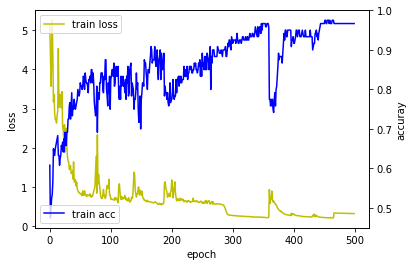

In [21]:
# Display acc, loss

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### Test model

In [22]:
predictions = model.predict(np.array(X_test).transpose([0,1,2,3]))

if bi_class==0:
    auc = roc_auc_score(Y_test, predictions, multi_class='raise')
    print('Multiclass Test AUC: ', auc)
else:
    auc = roc_auc_score(Y_test, predictions)
    print('Test AUC: ', auc)

Test AUC:  0.4642857142857143


In [23]:
frequency = np.zeros(len(Y_test[0]))

for i in range(len(predictions)):
    frequency[np.argmax(predictions[i])] +=1

frequency

array([21.,  2.])

In [24]:
if bi_class == 0:
    test_loss, test_acc, test_auc, test_F1 = model.evaluate(np.array(X_test).transpose([0,1,2,3]),  np.array(Y_test).transpose([0,1]), verbose=2)
    print('\nAccuracy:', test_acc)
else:
    test_loss, test_acc, test_auc = model.evaluate(np.array(X_test).transpose([0,1,2,3]),  np.array(Y_test).transpose([0,1]), verbose=2)
    print('\nAccuracy:', test_acc)

1/1 - 0s - loss: 2.9503 - accuracy: 0.6957 - auc: 0.7486

Accuracy: 0.695652186870575


In [25]:
## Test Confusion Matrix

flatten_Y_test = []
flatten_predictions = []

for i in range(len(Y_test)):
    if Y_test[i][0] == 1:
        flatten_Y_test.append(0)
    else:
        flatten_Y_test.append(1)


for i in range(len(predictions)):
    if predictions[i][0] == 1:
        flatten_predictions.append(0)
    else:
        flatten_predictions.append(1)
        

conf_mat = confusion_matrix(flatten_Y_test, flatten_predictions)
print(conf_mat)

tn, fp, fn, tp = conf_mat.ravel()
print(tn, fp, fn, tp)
print('Neg %:', tn/(tn+fp), 'Pos %:', tp/(tp+fn))

[[8 8]
 [4 3]]
8 8 4 3
Neg %: 0.5 Pos %: 0.42857142857142855
